In [1]:
import sys
from pathlib import Path
import cv2
import numpy as np
import h5py
import matplotlib.pyplot as plt
import dlib
src = Path.cwd().parent / 'src'
sys.path.append(str(src))

from config import PREPROCESSED_DATA_DIR

In [2]:
classifier_path = str(src / 'external_utils/haarcascade_frontalface_default.xml')
classifier = cv2.CascadeClassifier(classifier_path)

In [3]:
h5_file = h5py.File(PREPROCESSED_DATA_DIR / 'videos.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'D:\Image Processing Course Project\UBFC-RPPG\preprocessed_data\videos\videos.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
def get_face_coordinates(h5_file: h5py.File, dataset_name: str, classifier: cv2.CascadeClassifier) -> tuple[int]:
    idx = 0
    while True:
        frame = h5_file[dataset_name][idx]
        faces = classifier.detectMultiScale(frame)
        try:
            return faces[0].tolist()
        except IndexError:
            idx += 1

In [ ]:
def crop_frames(h5_file: h5py.File, dataset_name: str, x, y, w, h) -> np.ndarray:
    pady = 30
    return np.array(h5_file[dataset_name][:, y - pady:y+h, x:x+w, :])

In [ ]:
predictor_path = str(src / 'external_utils/shape_predictor_81_face_landmarks.dat')
face_detector = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor(predictor_path)

In [ ]:
def get_landmarks(frames: np.ndarray, detector, predictor):
    idx = 0
    while True:
        frame = cv2.cvtColor(frames[idx], cv2.COLOR_RGB2GRAY)
        face = detector(frame)[0]
        landmarks = predictor(frame, face)
        return [(landmarks.part(i).x, landmarks.part(i).y) for i in range(81)]

In [ ]:
face_coordinates = get_face_coordinates(h5_file, 'subject1', classifier)
cropped_frames = crop_frames(h5_file, 'subject1', *face_coordinates)
landmarks = get_landmarks(cropped_frames, face_detector, landmark_predictor)

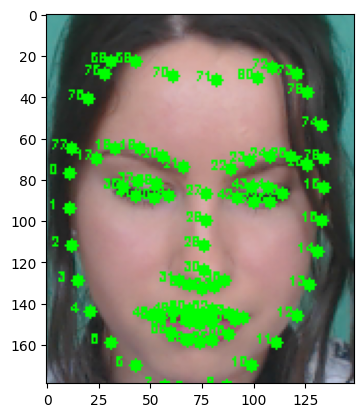

In [ ]:
frame = cropped_frames[20].copy()
for i, landmark in enumerate(landmarks):
    cv2.circle(frame, landmark, radius=3, color=(0, 255, 0), thickness=-1)
    cv2.putText(frame, str(i), (landmark[0] - 10, landmark[1]), cv2.FONT_HERSHEY_SIMPLEX, .2, (0, 255, 0))
plt.imshow(frame)

In [ ]:
def _new_landmark(landmarks, idx_x, idx_y):
    '''
    Generate a point that consists of the x of idx_x and y of idx_y.
    '''
    return (landmarks[idx_x][0], landmarks[idx_y][1])

def generate_landmarks(lst, landmarks):
    out = []
    for lm in lst:
        if type(lm) == int:
            out.append(landmarks[lm])
        elif type(lm) == tuple:
            out.append(_new_landmark(landmarks, lm[0], lm[1]))
    return out

In [ ]:
forehead_landmarks = generate_landmarks([
    (79, 74), 79, 73, 72, 69, 76, (76, 75), (75, 74)
], landmarks)

In [ ]:
def crop_by_landmarks(frames: np.ndarray, landmarks: list[tuple]) -> np.ndarray:
    mask = np.zeros_like(frames)
    landmarks = np.array([landmarks])
    cv2.fillPoly(mask, landmarks, [255] * 3)
    masked_image = cv2.bitwise_and(frames, mask)

    x_min, x_max, y_min, y_max = (landmarks[..., 0].min(),
                                landmarks[..., 0].max(),
                                landmarks[..., 1].min(),
                                landmarks[..., 1].max()
                                )
    return masked_image[y_min:y_max, x_min:x_max, :]

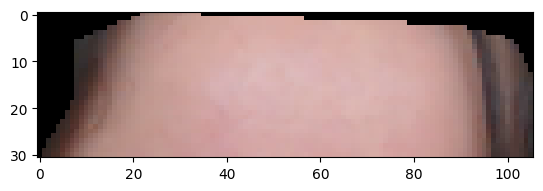

In [ ]:
masked_image = crop_by_landmarks(cropped_frames[20].copy(), forehead_landmarks)
plt.imshow(masked_image)

In [ ]:
from functools import reduce

def soriano200_mask(image):
    R, G, B = image.transpose(2, 0, 1)
    # TODO
    
def kovac2003(image):
    R, G, B = image.transpose(2, 0, 1)
    masks = [
        R > 95,
        G > 40,
        B > 20,
        image.max(axis=2) - image.min(axis=2) > 15,
        np.abs(R - G) > 15,
        R > G,
        R > B
    ]
    return reduce(np.bitwise_and, masks).astype(np.uint8)

def cheddad2009(image):
    R, G, B = image.transpose(2, 0, 1)
    e = 0.2989 * R + 0.5870 * G + 0.1402 * B - np.stack([G, B], -1).max(-1)
    return ((e <= 30.0135) >= 6.4031).astype(np.uint8)

def mask_image(image, mask):
    return cv2.bitwise_and(image, image, mask=mask)

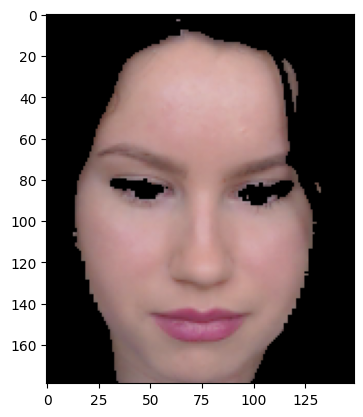

In [ ]:
plt.imshow(
    cv2.bitwise_and(cropped_frames[0].copy(
    ), cropped_frames[0].copy(), mask=kovac2003(cropped_frames[0].copy()))
)

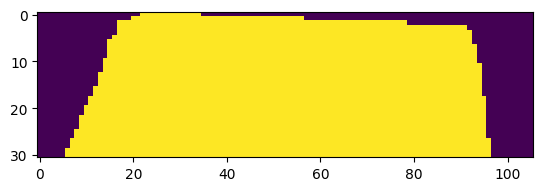

In [ ]:
from skimage.measure import regionprops, label

def get_largest_area(mask):
    rps = regionprops(label(mask))
    coords = rps[np.argmax([r.area for r in rps])].coords.T
    out = np.zeros_like(mask)
    out[tuple(coords)] = 1
    return out

plt.imshow(get_largest_area(kovac2003(masked_image)))

In [ ]:
def _get_frame_landmarks(frame: np.ndarray, detector, predictor):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    face = detector(gray)[0]
    landmarks = predictor(gray, face)
    return [(landmarks.part(i).x, landmarks.part(i).y) for i in range(81)]


def _get_or_generate_frame_forehead_landmarks(frame_landmarks: list[tuple]):
    forehead_landmarks = []
    forehead_lst = [(79, 74), 79, 73, 72, 69, 76, (76, 75), (75, 74)]
    for lm in forehead_lst:
        if type(lm) == int:
            # If `lm` is an int, it is the index of a landmark
            forehead_landmarks.append(frame_landmarks[lm])
        elif type(lm) == tuple:
            # If `lm` is a tuple, generate a point that consists of the x of the first element and y of the second element.
            forehead_landmarks.append((
                frame_landmarks[lm[0]][0], frame_landmarks[lm[1]][1]))
    return forehead_landmarks


###################################################################
# FUNCTIONS THAT OPERATE ON A BATCH OF FRAMES

def get_forehead_landmarks_every_nth_frame(frames: np.ndarray, n: int, detector, predictor):
    landmarks = []
    for i in range(0, len(frames), n):
        frame_landmarks = _get_frame_landmarks(frames[i], detector, predictor)
        frame_forehead_landmarks = _get_or_generate_frame_forehead_landmarks(
            frame_landmarks)
        for _ in range(n):
            landmarks.append(frame_forehead_landmarks)
    return np.array(landmarks)


def crop_frames_by_landmarks(frames: np.ndarray, landmarks: np.ndarray) -> np.ndarray:
    masked_frames = []
    for i, frame in enumerate(frames):
        frame_mask = np.zeros_like(frame)
        frame_landmarks = np.array([landmarks[i]])
        cv2.fillPoly(frame_mask, frame_landmarks, [255] * 3)
        masked_frame = cv2.bitwise_and(frame, frame_mask)
        masked_frames.append(masked_frame.copy())

    masked_frames = np.array(masked_frames)

    x_min, x_max, y_min, y_max = (landmarks[..., 0].min(),
                                  landmarks[..., 0].max(),
                                  landmarks[..., 1].min(),
                                  landmarks[..., 1].max()
                                  )
    return masked_frames[:, y_min:y_max, x_min:x_max, :]

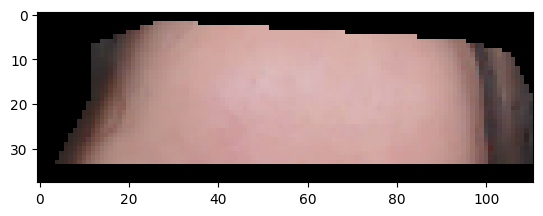

In [ ]:
plt.imshow(crop_frames_by_landmarks(
    cropped_frames,
    get_forehead_landmarks_every_nth_frame(
    cropped_frames, 10, face_detector, landmark_predictor)
)[120])

In [ ]:
with h5py.File(r'd:\Image Processing Course Project\UBFC-RPPG\preprocessed_data\foreheads.h5') as f:
    test = np.array(f['subject3'])

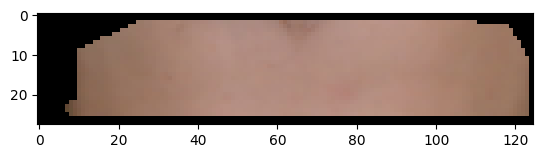

In [ ]:
plt.imshow(
    test[100]
)

In [ ]:
def _get_kovac_mask_for_frame(frame):
    R, G, B = frame.transpose(2, 0, 1)
    masks = [
        R > 95,
        G > 40,
        B > 20,
        frame.max(axis=2) - frame.min(axis=2) > 15,
        np.abs(R - G) > 15,
        R > G,
        R > B
    ]
    return reduce(np.bitwise_and, masks).astype(np.uint8)


def _get_largest_area_in_mask(mask):
    rps = regionprops(label(mask))
    coords = rps[np.argmax([r.area for r in rps])].coords.T
    out = np.zeros_like(mask)
    out[tuple(coords)] = 1
    return out.astype(np.uint8)

def segment_forehead(frames: np.ndarray):
    masks = []
    for frame in frames:
        kovac = _get_kovac_mask_for_frame(frame)
        mask = _get_largest_area_in_mask(kovac)
        masks.append(np.stack([mask] * 3, axis=-1))
    masks = np.array(masks)
    print(masks.shape)
    return frames * masks

In [ ]:
fh = segment_forehead(test)

(1547, 38, 111, 3)


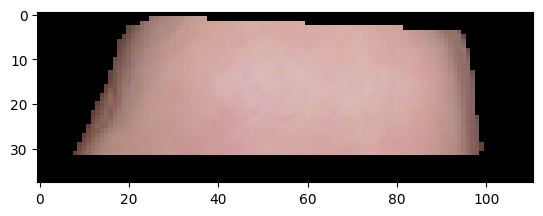

In [ ]:
plt.imshow(fh[5])